# LELA 60342 Research Methods in Computational and Corpus Linguistics 2
### Week 6¶

Today we are going to learn about using Pytorch to perform classification with sequence models.

The dataset we are going to work with consists of just over 10,000 surnames, labelled with 18 different nationalities. The first tasks will be to learn a classifier that can accurately assign a nationality to previously unseen surnames. To do this we will use an LSTM.

In [62]:
! wget https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/surnames_data.csv

--2025-03-06 12:12:01--  https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/surnames_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179708 (175K) [text/plain]
Saving to: ‘surnames_data.csv.1’

surnames_data.csv.1 100%[===================>] 175.50K  --.-KB/s    in 0.004s  

2025-03-06 12:12:02 (39.3 MB/s) - ‘surnames_data.csv.1’ saved [179708/179708]



We read the data into a Pandas dataframe:

In [220]:
import pandas as pd
import torch
surnames_df=pd.read_csv("surnames_data.csv")
surnames_df

,nationality,surname
0,Arabic,Totah
1,Arabic,Abboud
2,Arabic,Fakhoury
3,Arabic,Srour
4,Arabic,Sayegh
...,...,...
10975,Vietnamese,Dinh
10976,Vietnamese,Phung
10977,Vietnamese,Quang
10978,Vietnamese,Vu


In [ ]:
We then use hierachical indexing in Pandas to represent the data as sequences of separate characters

In [221]:
import pandas as pd
import torch
surnames_df=pd.read_csv("surnames_data.csv")

chars=[]
index_1=[]
index_2=[]
for i,row in surnames_df.iterrows():
    chars.extend(list(row.surname))
    index_1.extend([i]*len(row.surname))
    index_2.extend(range(len(row.surname)))

surnames_chars = pd.DataFrame(chars,index=[index_1,index_2])
surnames_chars.columns = ["chars"]
surnames_chars

chars
0     0     T
      1     o
      2     t
      3     a
      4     h
...       ...
10977 4     g
10978 0     V
      1     u
10979 0     H
      1     a

[73143 rows x 1 columns]

We can then use the Pandas function get_dummies to produce one-hot codings of the characters

In [ ]:
surnames_oh=pd.get_dummies(surnames_chars.chars,dtype=int)
surnames_oh

And the nationalities

In [222]:
nationalities_oh=pd.get_dummies(surnames_df.nationality,dtype=int)
nationalities_oh

,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


We will then turn these into tensors for input to PyTorch and in particular to an LSTM layer. We want a tensor with the shape [Number_of_names, Number_of_characters_in name, Size_of_alphabet]. \

However the LSTM layer requires that all sequence be of the same length and so we pad our tensors by adding N tensors of zeros of the length of the one hot codings to the beginning of each name. So that the tensor actually has the form [Number_of_names, Number_of_characters_in_the_longest_name, Size_of_alphabet]

We do this using the function ZeroPad1d which takes as an argument a tuple with the following entries: padding_left, padding_right, padding_above, padding below.





In [67]:
max_length=max([t[1] for t in surnames_oh.index])
X = [0] * (max(surnames_oh.index)[0]+1)
y = [0] * (max(nationalities_oh.index)+1)
for ind in surnames_oh.index:
    s=torch.from_numpy(surnames_oh.loc[ind[0]].values).to(dtype=torch.float)
    m = nn.ZeroPad1d((0,0,max_length-len(s),0))
    #print(m(s).shape)
    X[ind[0]] = m(s).cuda()
    y[ind[0]] = torch.from_numpy(nationalities_oh.loc[ind[0]].values).to(dtype=torch.float).cuda()
X=torch.stack(X)
y=torch.stack(y)

In [223]:
X.shape

torch.Size([10980, 16, 84])

In [224]:
y.shape

torch.Size([10980, 18])

### LSTM layers in PyTorch

LSTM layers can be specified as follows. We need to specify the size of the input (e.g. the length our one-hot vectors), the size of the hidden layer to use, the number of layers to include. And because of the way that our data is configured we use the batch_first flag.


In [248]:
input=torch.randn((10,10,10))
lstm = nn.LSTM(input_size=10, hidden_size=5, num_layers=1, batch_first=True)
output=lstm(input)
hidden=output[0]

The output of from the output is first the hidden layers from each step of the sequence and second the cell states from each step. Here we are interested in the hidden layer values as it is the hidden layer from final step for each sequence that we will pass on to a linear layer to perform classification.

In [251]:
hidden.shape

torch.Size([10, 10, 5])

In [217]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
n_classes = 18

class SeqModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=84, hidden_size=42, num_layers=1, batch_first=True)
        self.linear = nn.Linear(42, n_classes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        x = self.linear(x)
        return x

Now we have the model we can split the data then train and then test. We will use CrossEntropyLoss because our output is an 18-class softmax. We will use batch training.

In [218]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

Text(0, 0.5, 'loss')

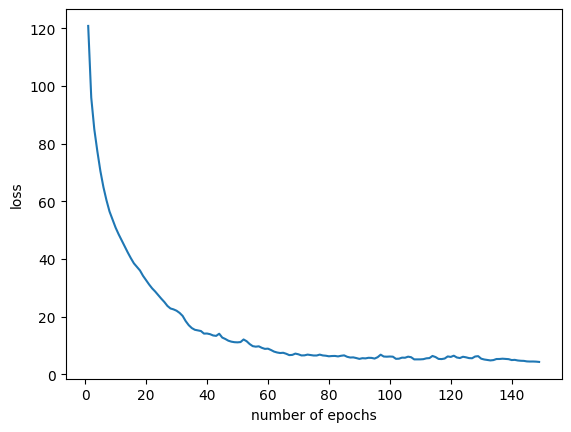

In [219]:
from sklearn.utils import gen_batches
import matplotlib.pyplot as plt
n_epochs = 150
batch_size = 128
model = SeqModel()
model.to("cuda")
ce_loss=[]
optimizer = optim.Adam(model.parameters(),lr=0.005)
loss_fn = nn.CrossEntropyLoss()

for i in range(n_epochs):
    cumul_loss = 0.0
    batches = gen_batches(X_train.shape[0],batch_size)
    cumul_loss=0.0
    for k in batches:
          inputs=X_train[k]
          outputs=y_train[k]
          y_pred = model(inputs)
          loss = loss_fn(y_pred, outputs)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          cumul_loss += loss.item()
    ce_loss.append(cumul_loss)

plt.plot(range(1,n_epochs),ce_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")










Our accuracy is as follows:

In [204]:
import numpy as np
y_test_pred=[np.argmax(x.cpu().detach().numpy()) for x in model(X_test)]
np.mean([int(x == np.argmax(y_test.cpu().detach().numpy()[i])) for i,x in enumerate(y_test_pred)])

0.7176684881602914

We can try the model out of individual names as follows:

In [216]:
name="bannard"
torch.manual_seed(42)
charset=list(surnames_oh.columns.values)
nationalities=list(nationalities_oh.columns.values)
oh = torch.zeros(16,len(charset))
for i,c in enumerate(name):
    oh[16-len(name)+i,charset.index(c)] = 1.0
oh=oh.to("cuda")
print(oh.shape)
pred=model(torch.unsqueeze(oh,0))
nationalities[np.argmax(pred.cpu().detach().numpy())]

torch.Size([16, 84])


'French'

### Intent classification with LSTMs

Now we are going to work with some sentences - utterances input to a dialogue system assigned with the speaker intent. \

'PlayMusic', e.g. "play easy listening" \
'AddToPlaylist' e.g. "please add this song to road trip" \
'RateBook' e.g. "give this novel 5 stars" \
'SearchScreeningEvent' e.g. "give me a list of local movie times" \
'BookRestaurant' e.g. "i'd like a table for four at 7pm at Asti" \
'GetWeather' e.g. "what's it like outside" \
'SearchCreativeWork' "show me the new James Bond trailer" \



Problem 1: Build and train an LSTM-based classifier using a training subset of the data that can correctly classify a test subset of the data.

I have prebuilt the tensors containing word embeddings for you:

In [253]:
!wget https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/utts_emb.pt.gz
!gunzip utts_emb.pt.gz
!wget https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/intents_emb.pt
X_utts=torch.load("utts_emb.pt")
y_intents=torch.load("intents_emb.pt")

--2025-03-06 15:41:48--  https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/utts_emb.pt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8541608 (8.1M) [application/octet-stream]
Saving to: ‘utts_emb.pt.gz’

utts_emb.pt.gz      100%[===================>]   8.15M  --.-KB/s    in 0.07s   

2025-03-06 15:41:51 (118 MB/s) - ‘utts_emb.pt.gz’ saved [8541608/8541608]



In [257]:
X_utts.shape

torch.Size([2100, 23, 300])

In [262]:
y_intents.shape

torch.Size([2100, 7])

In [272]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_utts, y_intents, test_size=0.2, random_state=30)
X_train=X_train.to("cuda")
X_test=X_test.to("cuda")
y_train=y_train.to("cuda")
y_test=y_test.to("cuda")


Once the model is trained you can calculate its accuracy as follows:


In [ ]:
import numpy as np
y_test_pred=[np.argmax(x.cpu().detach().numpy()) for x in model(X_test)]
np.mean([int(x == np.argmax(y_test.cpu().detach().numpy()[i])) for i,x in enumerate(y_test_pred)])

Problem 3: Starting from the Pandas data_frame intent_classification (imported as below), compile the data into the format needed by your model. The data frame is hierachically indexed for utterance and word, so that the format is almost identical to the name data. Once you have compiled the data use it to train your model above.

In [287]:
!wget https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/intent_classification.pickle

--2025-03-06 16:17:28--  https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/intent_classification.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19335663 (18M) [application/octet-stream]
Saving to: ‘intent_classification.pickle’

intent_classificati 100%[===================>]  18.44M  --.-KB/s    in 0.05s   

2025-03-06 16:17:29 (354 MB/s) - ‘intent_classification.pickle’ saved [19335663/19335663]



In [288]:
intent_classification = pd.read_pickle("intent_classification.pickle")


In [289]:
intent_classification

0         1         2         3         4         5         6    \
0    0  0.031982 -0.125000  0.186523  0.181641 -0.255859  0.115723  0.107422   
     4  0.248047 -0.125977  0.096680  0.117188 -0.435547  0.195312 -0.017334   
     5  0.026733 -0.090820  0.027832  0.204102  0.006226 -0.090332  0.022583   
     6  0.112793 -0.229492  0.017822  0.192383 -0.225586  0.009338 -0.017090   
     7  0.038818 -0.216797 -0.053467  0.038818 -0.077148  0.018311 -0.089355   
...          ...       ...       ...       ...       ...       ...       ...   
2099 1  0.109375  0.140625 -0.031738  0.166016 -0.071289  0.015869 -0.003113   
     2  0.220703 -0.251953 -0.204102  0.294922 -0.141602 -0.095703 -0.039307   
     3  0.031738 -0.106445  0.002411  0.052490  0.186523 -0.227539 -0.005951   
     4  0.110840 -0.158203  0.020752  0.166992 -0.099121 -0.154297  0.020020   
     6  0.125977 -0.031494  0.015747  0.053223 -0.001556  0.025269  0.185547   

             7         8         9    ...       290       291       292  \
0    0  0.045410  0.337891  0.004425  ...  0.196289  0.227539  0.039551   
     4 -0.083984  0.002975  0.099609  ...  0.201172 -0.071289 -0.002792   
     5 -0.161133  0.132812  0.061035  ...  0.026855 -0.027954  0.030884   
     6 -0.172852  0.195312 -0.054443  ...  0.433594  0.255859 -0.200195   
     7 -0.234375 -0.065430 -0.137695  ... -0.151367  0.008789 -0.259766   
...          ...       ...       ...  ...       ...       ...       ...   
2099 1 -0.084961 -0.048584  0.055664  ... -0.064941  0.004059  0.010559   
     2 -0.337891  0.236328  0.102539  ... -0.009399  0.113281 -0.431641   
     3 -0.089355  0.076660  0.105469  ... -0.053955  0.016235 -0.129883   
     4 -0.265625  0.036865  0.089355  ...  0.001999 -0.035645 -0.212891   
     6 -0.014404  0.125977  0.128906  ...  0.067383 -0.012573 -0.116699   

             293       294       295       296       297       298       299  
0    0 -0.055176 -0.112305 -0.208984 -0.023682 -0.119629  0.054199  0.014343  
     4  0.102051  0.047852  0.145508 -0.242188  0.507812  0.255859  0.174805  
     5  0.040527 -0.130859  0.083008  0.015747 -0.116699 -0.029419 -0.070801  
     6  0.277344  0.046387 -0.320312 -0.024536 -0.261719 -0.136719 -0.081543  
     7 -0.144531  0.121094  0.074219  0.233398 -0.090820  0.161133  0.127930  
...          ...       ...       ...       ...       ...       ...       ...  
2099 1  0.064453  0.015259 -0.076660  0.003662  0.007660  0.120117 -0.179688  
     2 -0.349609  0.037109 -0.134766 -0.029907 -0.208984  0.236328  0.078613  
     3 -0.145508 -0.099121  0.043701 -0.022095 -0.062500 -0.103027  0.029297  
     4 -0.057129 -0.194336  0.133789  0.012024  0.151367 -0.165039  0.019775  
     6  0.068359 -0.059570  0.055908 -0.157227 -0.083496 -0.095215  0.041748  

[16058 rows x 300 columns]